# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
from unityagents import UnityEnvironment
import os
import torch
import torch.nn.functional as F
import torch.distributed as dist
from torch.autograd import Variable
import numpy as np
from collections import deque, namedtuple

def transpose_list(mylist):
    return list(map(list, zip(*mylist)))

def transpose_to_tensor(input_list):
    make_tensor = lambda x: torch.tensor(x, dtype=torch.float)
    return list(map(make_tensor, zip(*input_list)))


# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L11
def soft_update(target, source, tau):
    """
    Perform DDPG soft update (move target params toward source based on weight
    factor tau)
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
        tau (float, 0 < x < 1): Weight factor for update
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L15
def hard_update(target, source):
    """
    Copy network parameters from source to target
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

# https://github.com/seba-1511/dist_tuto.pth/blob/gh-pages/train_dist.py
def average_gradients(model):
    """ Gradient averaging. """
    size = float(dist.get_world_size())
    for param in model.parameters():
        dist.all_reduce(param.grad.data, op=dist.reduce_op.SUM, group=0)
        param.grad.data /= size


def onehot_from_logits(logits, eps=0.0):
    """
    Given batch of logits, return one-hot sample using epsilon greedy strategy
    (based on given epsilon)
    """
    # get best (according to current policy) actions in one-hot form
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    if eps == 0.0:
        return argmax_acs
    # get random actions in one-hot form
    rand_acs = Variable(torch.eye(logits.shape[1])[[np.random.choice(
        range(logits.shape[1]), size=logits.shape[0])]], requires_grad=False)
    # chooses between best and random actions using epsilon greedy
    return torch.stack([argmax_acs[i] if r > eps else rand_acs[i] for i, r in
                        enumerate(torch.rand(logits.shape[0]))])

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """Sample from Gumbel(0, 1)"""
    U = Variable(tens_type(*shape).uniform_(), requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def gumbel_softmax_sample(logits, temperature):
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data))
    return F.softmax(y / temperature, dim=1)

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def gumbel_softmax(logits, temperature=0.5, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
      logits: [batch_size, n_class] unnormalized log-probs
      temperature: non-negative scalar
      hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        y_hard = onehot_from_logits(y)
        y = (y_hard - y).detach() + y
    return y


In [2]:

class TennisEnv:
    def __init__(self):
        self.env = UnityEnvironment(file_name="Tennis.app")

        # get the default brain
        self.brain_name = self.env.brain_names[0]
        self.brain = self.env.brains[self.brain_name]
        states, full_state, env_info = self.reset(True)
        # number of agents
        self.num_agents = len(env_info.agents)
        print('Number of agents:', self.num_agents)
        # size of each action
        self.action_size = self.brain.vector_action_space_size
        print('Size of each action:', self.action_size)
        # examine the state space
        self.state_size = states.shape[-1]
#         print('There are {} agents. Each observes a state with length: {}'.format(2, self.state_size))
#         print('The state for the first agent looks like:', states[0, :])
#         print('The state for the second agent looks like:', states[1, :])
#         print('The full state is:', full_state)

    def reset(self, train_mode=True):
        env_info = self.env.reset(train_mode=train_mode)[self.brain_name]
        states = env_info.vector_observations
        full_state = self.get_full_state(states)
        return states, full_state, env_info

    def step(self, actions):
        env_info = self.env.step(actions)[self.brain_name]  # send all actions to the environment
        next_states = env_info.vector_observations
        next_state_full = self.get_full_state(next_states)
        rewards = np.array(env_info.rewards)  # get reward (for each agent)
        dones = np.array(env_info.local_done)
        return next_states, next_state_full, \
               rewards, dones, env_info


    def get_full_state(self, x):
        return np.concatenate((x[0], x[1]))

    def close(self):
        self.env.close()

In [3]:
import numpy as np
import torch
class OUNoise:

    def __init__(self, action_dimension, scale=0.1, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return torch.tensor(self.state * self.scale).float()

In [4]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self,size):
        self.size = size
        self.deque = deque(maxlen=self.size)
        self.experience = namedtuple("Experience", field_names=["state", "state_full", 
                                                                "action", "reward", "next_state", 
                                                                "next_state_full", "done"])

    def push(self, state, state_full, action, reward, next_state, next_state_full, done):
        """push into the buffer"""
        e = self.experience(state, state_full, action, reward, next_state, next_state_full, done)
        self.deque.append(e)

    def sample(self, batchsize):
        """sample from the buffer"""
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.deque, k=batchsize)

        state = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        state_full = torch.from_numpy(np.vstack([e.state_full for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.stack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_state = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(
            device)
        next_state_full = torch.from_numpy(np.vstack([e.next_state_full for e in experiences if e is not None])).float().to(
            device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(
            device)

        return (state, state_full, actions, rewards, next_state, next_state_full, dones)


    def __len__(self):
        return len(self.deque)


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Actor, self).__init__()
        fc = [256, 128, 128, 64]
        self.bn = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc[0])
        self.bn1 = nn.BatchNorm1d(fc[0])
        self.fc2 = nn.Linear(fc[0], fc[1])
        self.bn2 = nn.BatchNorm1d(fc[1])
        self.fc3 = nn.Linear(fc[1], fc[2])
        self.bn3 = nn.BatchNorm1d(fc[2])
        self.fc4 = nn.Linear(fc[2], fc[3])
        self.bn4 = nn.BatchNorm1d(fc[3])
        self.fc5 = nn.Linear(fc[-1], action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.fc5.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(self.bn(state)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        return x

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Critic, self).__init__()
        fc = [512, 256, 128, 64]
        self.bn = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size+action_size, fc[0])
        self.bn1 = nn.BatchNorm1d(fc[0])
        self.fc2 = nn.Linear(fc[0], fc[1])
        self.bn2 = nn.BatchNorm1d(fc[1])
        self.fc3 = nn.Linear(fc[1], fc[2])
        self.bn3 = nn.BatchNorm1d(fc[2])
        self.fc4 = nn.Linear(fc[2], fc[3])
        self.bn4 = nn.BatchNorm1d(fc[3])
        self.fc5 = nn.Linear(fc[3], 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(*hidden_init(self.fc4))
        self.fc5.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action1, action2):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((self.bn(state), action1, action2), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return self.fc5(x)

In [19]:
Actor(24, 2).to(device)

Actor(
  (bn): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
Critic(48, 1).to(device)

Critic(
  (bn): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=49, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
from torch.optim import Adam
import torch
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class DDPGAgent:
    def __init__(self, in_actor, out_actor, in_critic, lr_actor=1.0e-4, lr_critic=1.0e-3):
        super(DDPGAgent, self).__init__()
        self.actor = Actor(in_actor, out_actor).to(device)
        self.critic = Critic(in_critic, out_actor*2).to(device)
        self.target_actor = Actor(in_actor, out_actor).to(device)
        self.target_critic = Critic(in_critic, out_actor*2).to(device)
        self.noise = OUNoise(out_actor, scale=1.0)

        # initialize targets same as original networks
        hard_update(self.target_actor, self.actor)
        hard_update(self.target_critic, self.critic)

        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr_critic)

    def act(self, state, noise=0.0):
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy() + noise*self.noise.noise()
        self.actor.train()
        return np.clip(action, -1, 1)

    def target_act(self, state, noise=0.0):
        state = state.to(device)
        action = self.target_actor(state).cpu().data.numpy() + noise*self.noise.noise()
        return np.clip(action, -1, 1)

In [8]:
class MADDPG:
    def __init__(self, discount_factor=0.99, tau=1e-3):
        super(MADDPG, self).__init__()
        self.maddpg_agent = [
            DDPGAgent(24, 2, 48), # actor net:
            DDPGAgent(24, 2, 48)  # critic net:
        ]
        self.n_agents = len(self.maddpg_agent)
        self.discount_factor = discount_factor
        self.tau = tau
        self.iter = 0

    def get_actors(self):
        """get actors of all the agents in the MADDPG object"""
        actors = [ddpg_agent.actor for ddpg_agent in self.maddpg_agent]
        return actors

    def get_target_actors(self):
        """get target_actors of all the agents in the MADDPG object"""
        target_actors = [ddpg_agent.target_actor for ddpg_agent in self.maddpg_agent]
        return target_actors

    def act(self, obs_all_agents, noise=0.0):
        """get actions from all agents in the MADDPG object"""
        actions = []
        obs_all_agents = torch.from_numpy(obs_all_agents).float().to(device)
        for i in range(self.n_agents):
            agent = self.maddpg_agent[i]
            state = obs_all_agents[i,:].view(1,-1)
            action = agent.act(state, noise).squeeze()
            actions.append(action)
        return actions

    def target_act(self, obs_all_agents, noise=0.0):
        """get target network actions from all the agents in the MADDPG object """
        target_actions = []
        for i in range(self.n_agents):
            agent = self.maddpg_agent[i]
            action = agent.target_act(obs_all_agents[:,i,:], noise)
            target_actions.append(action)
        return target_actions

    def update(self, samples, agent_number):
        """update the critics and actors of all the agents """

        # state[agent_number]
        state, state_full, action, reward, next_state, next_state_full, done = samples

        # state, next_state: batchsizex2x24
        # state_full, next_state_full: batchsizex48
        # action: batchsizex2x2
        # done, reward: batchsizex2

        agent_critic = self.maddpg_agent[0] # This is the shared critic
        agent = self.maddpg_agent[agent_number] # this is for the actor

        target_actions = self.target_act(next_state)
        with torch.no_grad():
            q_next = agent_critic.target_critic(next_state_full, target_actions[0], target_actions[1]).squeeze()
        y = reward[:, agent_number].squeeze() + self.discount_factor * q_next * (1 - done[:, agent_number].squeeze())
        q = agent_critic.critic(state_full, action[:,0,:], action[:,1,:]).squeeze()
        critic_loss = F.mse_loss(q, y)
        agent_critic.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent_critic.critic.parameters(), 1.0)
        agent_critic.critic_optimizer.step()

        #update actor network using policy gradient
        # shape: batchsize x 4
        # q_input is the actions from both agents
        q_input=[]
        for i in range(self.n_agents):
            acts = self.maddpg_agent[i].actor(state[:,i,:])
            if i == agent_number:
                q_input.append(acts)
            else:
                q_input.append(acts.detach())

        # get the policy gradient
        actor_loss = -agent_critic.critic(state_full, q_input[0], q_input[1]).mean()
        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 1)
        agent.actor_optimizer.step()

        # soft update the target network towards the actual networks
        self.update_targets(agent, agent_critic)

    def update_targets(self, agent, agent_critic):
        """soft update targets"""
        self.iter += 1
        soft_update(agent.target_actor, agent.actor, self.tau)
        soft_update(agent_critic.target_critic, agent_critic.critic, self.tau)
        agent.noise.reset()
            
            

In [9]:
import torch
import numpy as np
import os
from collections import deque

def seeding(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)

def main():
    seeding()
    # number of parallel agents
    number_of_agents = 2
    # number of training episodes.
    number_of_episodes = 5000
    max_t = 1000
    batchsize = 128
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 1
    noise_reduction = 0.9999

    tau = 1e-3   # soft update factor
    gamma = 0.99 # reward discount factor

    # how many episodes before update
    episode_per_update = 2

    model_dir= os.getcwd()+"/model_dir"
    os.makedirs(model_dir, exist_ok=True)

    torch.set_num_threads(number_of_agents*2)

    env = TennisEnv()
    
    # keep 5000 episodes worth of replay
    buffer = ReplayBuffer(int(1e5))
    
    # initialize policy and critic
    maddpg = MADDPG(discount_factor=gamma, tau=tau)

    # training loop
    scores_window = deque(maxlen=100)
    ep_scores = []

    # when to save: use a dictionary to track if a model at a given score (key/10) has been saved.
    save_on_scores = {5: False, 6: False, 9: False, 10: False, 11:False,
                      12: False, 13: False, 14: False, 15: False, 16:False,
                      17: False, 18: False, 19: False, 20: False}

    agent0_reward = []
    agent1_reward = []

    for episode in range(0, number_of_episodes):
        reward_this_episode = np.zeros((1, number_of_agents))
        state, state_full, env_info = env.reset()


        for agent in maddpg.maddpg_agent:
            agent.noise.reset()

        for episode_t in range(max_t):
            # explore = only explore for a certain number of episodes
            # action input needs to be transposed
            actions = maddpg.act(state, noise=noise)
            noise *= noise_reduction
            actions_for_env = torch.stack(actions).detach().numpy()

            # step forward one frame
            next_state, next_state_full, rewards, dones, info = env.step(actions_for_env)

            # add data to buffer
            buffer.push(state, state_full, actions_for_env, rewards, next_state, next_state_full, dones)

            reward_this_episode += rewards

            state = np.copy(next_state)
            state_full = np.copy(next_state_full)

            # update once after every episode_per_update
            if len(buffer) > batchsize and episode>0 and episode % episode_per_update==0:
                for a_i in range(number_of_agents):
                    samples = buffer.sample(batchsize)
                    maddpg.update(samples, a_i)

            if np.any(dones):
                break

        agent0_reward.append(reward_this_episode[0, 0])
        agent1_reward.append(reward_this_episode[0, 1])
        avg_rewards = max(reward_this_episode[0, 0], reward_this_episode[0, 1])
        scores_window.append(avg_rewards)
        cur_score = np.mean(scores_window)
        ep_scores.append(cur_score)
        if episode % 100 == 0 or episode == number_of_episodes-1:
            print('\rEpisode:{}, Rwd:{:.3f} vs. {:.3f}, Average Score:{:.4f}, Noise:{:.4f}'.format(episode,
                                                                              reward_this_episode[0, 0],
                                                                              reward_this_episode[0, 1],
                                                                              cur_score,noise))

        #saving model
        save_dict_list =[]
        save_info = False
        score_code = int(cur_score * 10)
        if score_code in save_on_scores.keys():
            if not(save_on_scores[score_code]):
                save_on_scores[score_code] = True
                save_info = True

        if save_info:
            for i in range(number_of_agents):
                save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                             'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                             'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                             'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
                save_dict_list.append(save_dict)

                torch.save(save_dict_list, 
                           os.path.join(model_dir, 'episode-{}-{}.pt'.format(episode,score_code)))

    env.close()

In [10]:
main()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]
The full state is: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.       

In [11]:
agent0 = DDPGAgent(24, 2, 48)
agent1 = DDPGAgent(24, 2, 48)
agent_file = torch.load('model_dir/episode-4140-16.pt', map_location='cpu')
agent0.actor.load_state_dict(agent_file[0]['actor_params'])
agent1.actor.load_state_dict(agent_file[1]['actor_params'])

In [14]:
env = TennisEnv()
max_t=1000
for ep in range(10):
    reward_this_episode = np.zeros((1, 2))
    state, state_full, env_info = env.reset(train_mode=False)
    for i in range(max_t):
        state=torch.tensor(state, dtype=torch.float)
        action0 = agent0.act(state[0,:].view(1,-1), 0).squeeze()
        action1 = agent1.act(state[1,:].view(1,-1), 0).squeeze()
        actions = torch.stack([action0, action1]).detach().numpy()
        next_state, next_state_full, rewards, dones, info = env.step(actions)
        reward_this_episode += rewards
        state = np.copy(next_state)
        state_full = np.copy(next_state_full)
        if np.any(dones):
            break

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]
The full state is: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.       

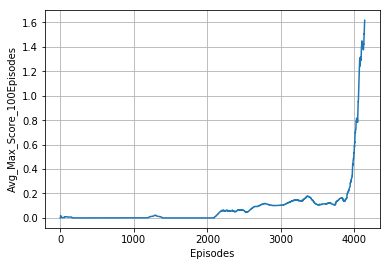

In [17]:
data = np.load('scores-4140-16.np')
s=data['avg_max_scores']
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s)
plt.xlabel('Episodes')
plt.ylabel('Avg_Max_Score_100Episodes')
plt.grid()